In [1]:
pip install natasha

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruBert-base")
bert = AutoModel.from_pretrained("sberbank-ai/ruBert-base")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [3]:
import pandas as pd
import numpy as np

In [4]:
# –ó–∞–≥—Ä—É–∑–∫–∞ –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ –ø–æ–¥–≥–æ—Ç–æ–≤–ª–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞
df_time_news = pd.read_csv("df_time_news.csv")  # –¥–∞—Ç–∞—Å–µ—Ç —Å –∫—É—Ä—Å–∞–º–∏ –∏ –Ω–æ–≤–æ—Å—Ç—è–º–∏, —Å–æ—Ö—Ä–∞–Ω–µ–Ω–Ω—ã–π –∏–∑ –ø—Ä–µ–¥—ã–¥—É—â–µ–≥–æ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞
df_time_news

date                                              title    Close  \
0    2020-01-10  –ò—Ä–∞–Ω –∑–∞—è–≤–∏–ª –æ –≥–æ—Ç–æ–≤–Ω–æ—Å—Ç–∏ –æ—Ç–ø—Ä–∞–≤–∏—Ç—å —á–µ—Ä–Ω—ã–µ —è—â–∏–∫...  60.9418   
1    2020-01-13  –ú–∞–∫—Ä–æ–Ω –∏ –ü—É—Ç–∏–Ω —Ä–µ—à–∏–ª–∏ —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å —è–¥–µ—Ä–Ω—É—é —Å–¥–µ–ª–∫—É...  61.2725   
2    2020-01-17  –†–æ—Å—Å–∏—è –æ—Ç–≤–µ—Ç–∏–ª–∞ –ì–µ—Ä–º–∞–Ω–∏–∏ –Ω–∞ –∑–∞—è–≤–ª–µ–Ω–∏—è –æ–± —É–±–∏—Ç–æ...  61.4780   
3    2020-01-20  –ë–æ–µ–≤–∏–∫–∏ –ø–æ–ø—ã—Ç–∞–ª–∏—Å—å –∞—Ç–∞–∫–æ–≤–∞—Ç—å —Ä–æ—Å—Å–∏–π—Å–∫—É—é –∞–≤–∏–∞–±–∞...  61.6000   
4    2020-01-22  –°–µ–Ω–∞—Ç–æ—Ä–æ–≤ –°–®–ê –Ω–∞—É—á–∏–ª–∏ –±–æ—Ä–æ—Ç—å—Å—è —Å –Ω–∞–∑–æ–π–ª–∏–≤—ã–º–∏ –∂...  62.0285   
..          ...                                                ...      ...   
793  2024-06-19  –¶–µ—Ä–µ–º–æ–Ω–∏—è –≤—Å—Ç—Ä–µ—á–∏ –ü—É—Ç–∏–Ω–∞ –∏ –ö–∏–º –ß–µ–Ω –´–Ω–∞ –Ω–∞—á–∞–ª–∞—Å...  83.5000   
794  2024-06-20  –ì–µ–Ω—Å–µ–∫ –ù–ê–¢–û –æ—Ç—Ä–µ–∞–≥–∏—Ä–æ–≤–∞–ª –Ω–∞ –¥–æ–≥–æ–≤–æ—Ä –†–æ—Å—Å–∏–∏ –∏ –°...  87.1850   
795  2024-06-21  –ë–∞—Å—Ç—Ä—ã–∫–∏–Ω —Ä–∞—Å—Å–∫–∞–∑–∞–ª –ø—Ä–æ –ø–ª–∞–Ω—ã –Ω–∞—Ü–∏—Å—Ç–æ–≤ –∏—Å—Ç—Ä–µ–±–∏...  89.0000   
796  2024-06-24  –ü–µ–Ω—Ç–∞–≥–æ–Ω —Å–ø—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–ª –Ω–∞–ø—Ä—è–∂–µ–Ω–Ω–æ—Å—Ç—å –æ—Ç–Ω–æ—à–µ–Ω–∏...  87.4500   
797  2024-06-25  –ê—Å—Å–∞–Ω–∂–∞ –æ—Å–≤–æ–±–æ–¥–∏–ª–∏ –∏–∑ –±—Ä–∏—Ç–∞–Ω—Å–∫–æ–π —Ç—é—Ä—å–º—ã –ü–µ–Ω—Ç–∞–≥...  87.7750   

     target    lag_1    lag_2    lag_3     sma_5  delta_week  
0         1  60.9418  61.5955  61.9555  61.73192     -1.6490  
1         1  61.2725  60.9418  61.5955  61.51042     -1.1075  
2         1  61.4780  61.2725  60.9418  61.44866     -0.3088  
3         1  61.6000  61.4780  61.2725  61.37756     -0.3555  
4         1  62.0285  61.6000  61.4780  61.46416      0.4330  
..      ...      ...      ...      ...       ...         ...  
793       1  83.5000  86.5000  89.0250  87.38000     -6.8750  
794       1  87.1850  83.5000  86.5000  87.08200     -1.4900  
795       0  89.0000  87.1850  83.5000  87.04200     -0.2000  
796       0  87.4500  89.0000  87.1850  86.72700     -1.5750  
797       0  87.7750  87.4500  89.0000  86.98200      1.2750  

[798 rows x 9 columns]

In [5]:
import re
import warnings

import nltk
import numpy as np
import pandas as pd
from datasets import load_dataset
from natasha import Doc, MorphVocab, NewsEmbedding, NewsMorphTagger, Segmenter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

nltk.download("stopwords")

warnings.filterwarnings("ignore", category=UserWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# === –ü—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ —Ç–µ–∫—Å—Ç–∞ (–ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—è –Ω–∞ —Ä—É—Å—Å–∫–æ–º —á–µ—Ä–µ–∑ Natasha) ===
segmenter = Segmenter()  # –†–∞–∑–¥–µ–ª—è–µ—Ç —Ç–µ–∫—Å—Ç –Ω–∞ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –∏ —Ç–æ–∫–µ–Ω—ã
emb = NewsEmbedding()  # –≠–º–±–µ–¥–¥–∏–Ω–≥–∏ –¥–ª—è –Ω–æ–≤–æ—Å—Ç–Ω—ã—Ö —Ç–µ–∫—Å—Ç–æ–≤
morph_tagger = NewsMorphTagger(emb)  # –û–ø—Ä–µ–¥–µ–ª—è–µ—Ç —á–∞—Å—Ç—å —Ä–µ—á–∏ –∏ –º–æ—Ä—Ñ–æ–ª–æ–≥–∏—á–µ—Å–∫–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
morph_vocab = MorphVocab()  # –ò—Å–ø–æ–ª—å–∑—É–µ—Ç—Å—è –¥–ª—è –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏–∏
stop_words = set(stopwords.words("russian"))  # –†—É—Å—Å–∫–∏–µ —Å—Ç–æ–ø-—Å–ª–æ–≤–∞ –∏–∑ NLTK


# === –§—É–Ω–∫—Ü–∏—è –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∏ —Ç–µ–∫—Å—Ç–∞ ===
def preprocess_text(text):
    # –ü—Ä–∏–≤–æ–¥–∏–º –∫ –Ω–∏–∂–Ω–µ–º—É —Ä–µ–≥–∏—Å—Ç—Ä—É –∏ —É–¥–∞–ª—è–µ–º –≤—Å—ë, –∫—Ä–æ–º–µ —Ä—É—Å—Å–∫–∏—Ö –±—É–∫–≤ –∏ –ø—Ä–æ–±–µ–ª–æ–≤
    text = re.sub(r"[^–∞-—è—ë–ê-–Ø–Å\\s]", " ", text.lower())

    # –û–±—Ä–∞–±–∞—Ç—ã–≤–∞–µ–º —Ç–µ–∫—Å—Ç —Å –ø–æ–º–æ—â—å—é Natasha
    doc = Doc(text)
    doc.segment(segmenter)  # –¢–æ–∫–µ–Ω–∏–∑–∞—Ü–∏—è
    doc.tag_morph(morph_tagger)  # –ú–æ—Ä—Ñ–æ–ª–æ–≥–∏—á–µ—Å–∫–∞—è —Ä–∞–∑–º–µ—Ç–∫–∞

    lemmas = []
    for token in doc.tokens:
        # –õ–µ–º–º–∞—Ç–∏–∑–∏—Ä—É–µ–º, –µ—Å–ª–∏ —É —Ç–æ–∫–µ–Ω–∞ –µ—Å—Ç—å –º–æ—Ä—Ñ–æ–ª–æ–≥–∏—è
        if token.pos and token.feats:
            lemma = morph_vocab.lemmatize(token.text, token.pos, token.feats)
            # –£–±–∏—Ä–∞–µ–º —Å—Ç–æ–ø-—Å–ª–æ–≤–∞ –∏ —Å–ª–∏—à–∫–æ–º –∫–æ—Ä–æ—Ç–∫–∏–µ –ª–µ–º–º—ã
            if lemma not in stop_words and len(lemma) > 2:
                lemmas.append(lemma)

    # –í–æ–∑–≤—Ä–∞—â–∞–µ–º —Ç–µ–∫—Å—Ç –∏–∑ –ª–µ–º–º
    return " ".join(lemmas)

In [7]:
# –ü—Ä–∏–º–µ–Ω—è–µ–º –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫—É –∫ –∑–∞–≥–æ–ª–æ–≤–∫–∞–º: –æ—á–∏—Å—Ç–∫–∞ –∏ –ª–µ–º–º–∞—Ç–∏–∑–∞—Ü–∏—è
df_time_news["clean_title"] = df_time_news["title"].apply(preprocess_text)

# –ü—Ä–æ—Å–º–∞—Ç—Ä–∏–≤–∞–µ–º –ø–µ—Ä–≤—ã–µ —Å—Ç—Ä–æ–∫–∏ –ø–æ–ª—É—á–µ–Ω–Ω–æ–≥–æ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º–∞
df_time_news.head()

date                                              title    Close  \
0  2020-01-10  –ò—Ä–∞–Ω –∑–∞—è–≤–∏–ª –æ –≥–æ—Ç–æ–≤–Ω–æ—Å—Ç–∏ –æ—Ç–ø—Ä–∞–≤–∏—Ç—å —á–µ—Ä–Ω—ã–µ —è—â–∏–∫...  60.9418   
1  2020-01-13  –ú–∞–∫—Ä–æ–Ω –∏ –ü—É—Ç–∏–Ω —Ä–µ—à–∏–ª–∏ —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å —è–¥–µ—Ä–Ω—É—é —Å–¥–µ–ª–∫—É...  61.2725   
2  2020-01-17  –†–æ—Å—Å–∏—è –æ—Ç–≤–µ—Ç–∏–ª–∞ –ì–µ—Ä–º–∞–Ω–∏–∏ –Ω–∞ –∑–∞—è–≤–ª–µ–Ω–∏—è –æ–± —É–±–∏—Ç–æ...  61.4780   
3  2020-01-20  –ë–æ–µ–≤–∏–∫–∏ –ø–æ–ø—ã—Ç–∞–ª–∏—Å—å –∞—Ç–∞–∫–æ–≤–∞—Ç—å —Ä–æ—Å—Å–∏–π—Å–∫—É—é –∞–≤–∏–∞–±–∞...  61.6000   
4  2020-01-22  –°–µ–Ω–∞—Ç–æ—Ä–æ–≤ –°–®–ê –Ω–∞—É—á–∏–ª–∏ –±–æ—Ä–æ—Ç—å—Å—è —Å –Ω–∞–∑–æ–π–ª–∏–≤—ã–º–∏ –∂...  62.0285   

   target    lag_1    lag_2    lag_3     sma_5  delta_week  \
0       1  60.9418  61.5955  61.9555  61.73192     -1.6490   
1       1  61.2725  60.9418  61.5955  61.51042     -1.1075   
2       1  61.4780  61.2725  60.9418  61.44866     -0.3088   
3       1  61.6000  61.4780  61.2725  61.37756     -0.3555   
4       1  62.0285  61.6000  61.4780  61.46416      0.4330   

                                         clean_title  
0  –∏—Ä–∞–Ω –∑–∞—è–≤–∏—Ç—å –≥–æ—Ç–æ–≤–Ω–æ—Å—Ç—å –æ—Ç–ø—Ä–∞–≤–∏—Ç—å —á–µ—Ä–Ω—ã–π —è—â–∏–∫ ...  
1  –º–∞–∫—Ä–æ–Ω –ø—É—Ç–∏–Ω —Ä–µ—à–∏—Ç—å —Å–æ—Ö—Ä–∞–Ω–∏—Ç—å —è–¥–µ—Ä–Ω—ã–π —Å–¥–µ–ª–∫–∞ –∏...  
2  —Ä–æ—Å—Å–∏—è –æ—Ç–≤–µ—Ç–∏—Ç—å –≥–µ—Ä–º–∞–Ω–∏–∏ –∑–∞—è–≤–ª–µ–Ω–∏–µ —É–±–∏—Ç—å –±–µ—Ä–ª–∏...  
3  –±–æ–µ–≤–∏–∫ –ø–æ–ø—ã—Ç–∞—Ç—å—Å—è –∞—Ç–∞–∫–æ–≤–∞—Ç—å —Ä–æ—Å—Å–∏–π—Å–∫–∏–π –∞–≤–∏–∞–±–∞–∑...  
4  —Å–µ–Ω–∞—Ç–æ—Ä —Å—à–∞ –Ω–∞—É—á–∏—Ç—å –±–æ—Ä–æ—Ç—å—Å—è –Ω–∞–∑–æ–π–ª–∏–≤—ã–π –∂—É—Ä–Ω–∞–ª...

In [8]:
# –ò—Å–ø–æ–ª—å–∑—É–µ–º df_time_news, –∫–∞–∫ –≤ –ø—Ä–µ–¥—ã–¥—É—â–∏—Ö –º–æ–¥–µ–ª—è—Ö
text_col = "clean_title"
num_cols = ["lag_1", "lag_2", "lag_3", "sma_5", "delta_week"]

class MultiModalDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df[text_col].tolist()
        self.numerical = df[num_cols].values.astype(np.float32)
        self.labels = df["target"].values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        text = self.texts[idx]
        num = self.numerical[idx]
        label = self.labels[idx]

        encoded = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        item = {
            "input_ids": encoded["input_ids"].squeeze(),
            "attention_mask": encoded["attention_mask"].squeeze(),
            "numerical": torch.tensor(num),
            "label": torch.tensor(label)
        }
        return item

# –†–∞–∑–¥–µ–ª–µ–Ω–∏–µ –Ω–∞ train/test
split = len(df_time_news) - 200
train_ds = MultiModalDataset(df_time_news.iloc[:split], tokenizer)
test_ds = MultiModalDataset(df_time_news.iloc[split:], tokenizer)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=8)

In [10]:
class MultiModalModel(nn.Module):
    def __init__(self, bert, num_input_dim=5, hidden_dim=128):
        super().__init__()
        self.bert = bert
        self.linear_num = nn.Sequential(
            nn.Linear(num_input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.classifier = nn.Sequential(
            #nn.Linear(768 + hidden_dim, 2)  # 2 –∫–ª–∞—Å—Å–∞
            nn.Linear(768 + hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 2)
        )

    def forward(self, input_ids, attention_mask, numerical):
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0]
        num_out = self.linear_num(numerical)
        combined = torch.cat([bert_output, num_out], dim=1)
        logits = self.classifier(combined)
        return logits

model = MultiModalModel(bert).to(device)

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

# === –ë–∞–ª–∞–Ω—Å–∏—Ä–æ–≤–∫–∞ –∫–ª–∞—Å—Å–æ–≤ ===
class_counts = np.bincount(df_time_news.iloc[:split]["target"])
weights = torch.tensor([class_counts[1], class_counts[0]], dtype=torch.float32)
weights = weights / weights.sum()  # –Ω–æ—Ä–º–∞–ª–∏–∑–∞—Ü–∏—è
criterion = nn.CrossEntropyLoss(weight=weights.to(device))


# –¢—Ä–µ–Ω–∏—Ä–æ–≤–∫–∞ –Ω–∞ 3 —ç–ø–æ—Ö–∏
for epoch in range(3):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        numerical = batch["numerical"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, numerical)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} Loss: {total_loss / len(train_loader):.4f}")

Epoch 1: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [14:53<00:00, 11.91s/it]


Epoch 1 Loss: 0.7045


Epoch 2: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [14:46<00:00, 11.82s/it]


Epoch 2 Loss: 0.6888


Epoch 3: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 75/75 [14:35<00:00, 11.68s/it]

Epoch 3 Loss: 0.6809


In [12]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        numerical = batch["numerical"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids, attention_mask, numerical)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# –û—Ç—á–µ—Ç
print("\nüìã Classification Report:\n")
print(classification_report(all_labels, all_preds, digits=3))


üìã Classification Report:

              precision    recall  f1-score   support

           0      0.488     0.898     0.632        88
           1      0.763     0.259     0.387       112

    accuracy                          0.540       200
   macro avg      0.625     0.578     0.509       200
weighted avg      0.642     0.540     0.495       200



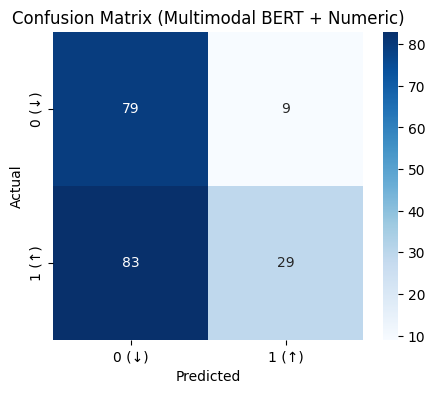

In [13]:
# –ú–∞—Ç—Ä–∏—Ü–∞ –æ—à–∏–±–æ–∫
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["0 (‚Üì)", "1 (‚Üë)"], yticklabels=["0 (‚Üì)", "1 (‚Üë)"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Multimodal BERT + Numeric)")
plt.show()